In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import copy
from scipy.interpolate import griddata

In [39]:
NU = 0.001
U_MAX = 0.3

# Řešení úlohy 2D statického proudění tekutiny v trubici s kruhovou překážkou

**2D statické Navier-Stokesovy rovnice:**
Budeme uvažovat stacionární úlohu proudění tekutiny v trubce s kruhovou překážkou. Úlohu budeme tedy řešit na oblasti $\Omega=\langle0;2,\!2\rangle\times\langle0;0,\!41\rangle\setminus B_r(0,\!2;0,\!2)$, kde $B_r(0,\!2;0,\!2)$ je kruhový váleček o poloměru $r=0,\!05$ se středem v bodě $(0,\!2;0,\!2)$.
\begin{align*}
     -\nu\left(\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}\right)+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}+\frac{\partial p}{\partial x}&=0,\\
-\nu\left(\frac{\partial^2v}{\partial x^2}+\frac{\partial^2v}{\partial y^2}\right)+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+\frac{\partial p}{\partial y}&=0,\\
u&=\frac{\partial \psi}{\partial y}\:\:\wedge\:\:v=-\frac{\partial\psi}{\partial x},\\
u(x,y)&=v(x,y)=0\:\:\mathrm{pro}\:\:x\in\langle0;2,\!2\rangle\wedge y=0\:\:\mathrm{a}\:\:(x,y)\in\partial B_r(0,\!2;0,\!2),\\
u(0,y)-\frac{4U(0,\!41-y)}{0,\!41^2}&=v(0,y)=0\:\:\mathrm{pro}\:\:y\in\langle0;0,\!41\rangle,\\
\nu\frac{\partial u}{\partial x}(2,\!2;y)-p(2,\!2;y)&=\frac{\partial v}{\partial x}(2,\!2;y)=0\:\:\mathrm{pro}\:\:y\in\langle0;0,\!41\rangle.
\end{align*}
kde $u$ je rychlost proudění tekutiny ve směru osy $x$, $v$ je rychlost proudění tekutiny ve směru osy $y$, $p$ je tlak tekutiny, $\nu>0$ určuje kinematickou viskozitu, $U=0,\!3$ je maximální rychlost proudění tekutiny.


Použijeme NN s 5 skrytými vrstvami s aktivační funkcí $tanh()$ s 20 neurony v každé vrstvě.
Trénování provedeme na 3000 rovnoměrně rozložených bodech uvnitř oblasti a 250 bodech na hranici oblasti.
Trénování provedeme ve 20000 epochách.
Využijeme optimalizátor Adam s learning rate $5\cdot 10^{-3}$ v prvních 19500 epochách a optimalizátor LBFGS s learning rate $10^{-1}$, maximálním počtem iterací v optimalizačním kroku $20$ a update history size $10$ na posledních 100 epoch.
Testování provedeme na 20000 náhodně rozložených bodech vygenerovaných metodou LHS.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro generování trénovacích bodů uvnitř oblasti,
- `generate_boundaries()` pro generování trénovacích bodů na hranici oblasti,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `generate_test_data_lhs()` pro vygenerování testovacích dat metodou LHS,
- `compute_derivatives_2d()` pro výpočet derivací.

**Krok 2:**
Definujeme funkce pro výpočet ztráty a funkce closure pro použití optimalizátoru LBFGS:
- `compute_loss()` pro výpočet ztrátové funkce,
- `closure()` pro použití optimalizátoru LBFGS.

**Krok 3:**
Vygenerujeme trénovací data, inicializujeme model a optimalizátor Adam.

**Krok 4:**
Spustíme trénovací smyčku na 20000 epochách se změnou optimalizátoru na LBFGS po 19500 epochách.
Vykreslíme graf znázorňující závislost ztráty na počtu epoch.
Uložíme nastavení modelu do souboru `pinn_navierstokes.pt`.

**Krok 5:**
Vykreslíme aproximace fyzikálních vlastností řešení úlohy pomocí NN.

In [40]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 2)  # Výstup je (psi, p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [41]:
# Krok 1.2: Funkce pro generování a vzkreslení rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    x = torch.linspace(0+1e-3, 2.2-1e-3, int(torch.sqrt(torch.tensor(no_points)))) 
    y = torch.linspace(0+1e-3, 0.41-1e-3, int(torch.sqrt(torch.tensor(no_points)))) 
    X, Y = torch.meshgrid(x, y)

    x = X.reshape(-1, 1)
    y = Y.reshape(-1, 1)
    
    circle_center = torch.tensor([0.2, 0.2])
    circle_radius = 0.05

    # Podmínka pro vyjmutí bodů v kruhové překážce
    points_in = (x - circle_center[0])**2 + (y - circle_center[1])**2 > circle_radius**2

    x_train = x[points_in].view(-1, 1)
    y_train = y[points_in].view(-1, 1)

    return (x_train, y_train)

def generate_boundaries(no_points): # Body na hranici
    x_bottom = torch.linspace(0,2.2, no_points).view(-1, 1)
    y_bottom = torch.zeros_like(x_bottom)
    y_left = torch.linspace(0, 0.41, no_points).view(-1, 1)
    x_left = torch.zeros_like(y_left)
    y_right = torch.linspace(0, 0.41, no_points).view(-1,1)
    x_right = 2.2*torch.ones_like(y_right)
    x_top = torch.linspace(0, 2.2, no_points).view(-1, 1)
    y_top = 0.41*torch.ones_like(x_top)
    # Kruhová hranice
    theta = torch.linspace(0,  2 * np.pi, no_points).view(-1, 1)
    circle_center = torch.tensor([0.2, 0.2])
    circle_radius = 0.05

    x_circle = circle_center[0] + circle_radius * torch.cos(theta)
    y_circle = circle_center[1] + circle_radius * torch.sin(theta)

    return (x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

def plot_boundaries(x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left,x_right, y_right, x_circle, y_circle):
    plt.figure(figsize=(24, 6))
    plt.scatter(x_bottom.numpy(), y_bottom.numpy(), label="Dolní",s=5, color='blue')
    plt.scatter(x_top.numpy(), y_top.numpy(), label="Horní",s=5, color='green')
    plt.scatter(x_left.numpy(), y_left.numpy(), label="Levé",s=5, color='red')
    plt.scatter(x_circle.numpy(), y_circle.numpy(), label="Váleček",s=5, color='magenta')
    plt.scatter(x_right.numpy(), y_right.numpy(), label="Pravé",s=5, color='orange')
    plt.scatter(x_train.numpy(), y_train.numpy(), label="Vnitřní",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Trénovací data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [42]:
# Krok 1.3: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici)
def generate_test_data_lhs(no_points):
    # Výpočet počtu bodů uvnitř oblasti a na hranici
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points
    no_boundary_circle_points = no_boundary_points // 5

    def latin_hypercube_sampling(num_samples, dim):
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Vnitřní body
    lhs_inside = latin_hypercube_sampling(no_inside_points * 2, 2)
    x_inside = lhs_inside[:, 0:1] * 2.2
    y_inside = lhs_inside[:, 1:2] * 0.41
    
    # Vyjmutí bodů uvnitř kružnice
    mask = ((x_inside - 0.2) ** 2 + (y_inside - 0.2) ** 2) >= 0.05 ** 2
    x_inside, y_inside = x_inside[mask], y_inside[mask]
    
    # Vybrání požadovaného počtu bodů
    x_inside = x_inside[:no_inside_points].view(-1, 1)
    y_inside = y_inside[:no_inside_points].view(-1, 1)
    
    # Body na hranici
    no_rect_boundary_points = no_boundary_points - no_boundary_circle_points
    lhs_boundary = latin_hypercube_sampling(no_rect_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_rect_boundary_points,))
    x_boundary = torch.zeros(no_rect_boundary_points, 1)
    y_boundary = torch.zeros(no_rect_boundary_points, 1)
    
    # Přiřazení bodů k hranicím
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0] * 2.2  # Horní
    y_boundary[side_assignments == 0] = 0.41

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1] * 2.2  # Dolní
    y_boundary[side_assignments == 1] = 0
    
    x_boundary[side_assignments == 2] = 0  # Levá
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] * 0.41
    
    x_boundary[side_assignments == 3] = 2.2  # Pravá
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3] * 0.41

    # Body na hranici kružnice
    theta = torch.linspace(0, 2 * np.pi, no_boundary_circle_points)
    x_circle = 0.2 + 0.05 * torch.cos(theta)
    y_circle = 0.2 + 0.05 * torch.sin(theta)

    # Spojení bodů
    x_test = torch.cat((x_inside, x_boundary.view(-1, 1), x_circle.view(-1, 1)), dim=0)
    y_test = torch.cat((y_inside, y_boundary.view(-1, 1), y_circle.view(-1, 1)), dim=0)
    
    return (x_test, y_test)

In [43]:
# Krok 1.4: Funkce pro výpočet derivací pomocí funkce autograd z knihovny PyTorch
def compute_derivatives_2d(model, x, y):
    inputs = torch.hstack((x,y)).requires_grad_(True)
    outputs = model(inputs)
    psi, p = outputs[:, 0], outputs[:, 1]
    
    # První derivace
    v = -grad(psi, inputs, torch.ones_like(psi), create_graph=True)[0][:, 0:1]  # v=-dpsi/dx
    u = grad(psi, inputs, torch.ones_like(psi), create_graph=True)[0][:, 1:2]  # u=dpsi/dy
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    v_x = grad(v, inputs, torch.ones_like(v), create_graph=True)[0][:, 0:1]  # dv/dx
    v_y = grad(v, inputs, torch.ones_like(v), create_graph=True)[0][:, 1:2]  # dv/dy
    p_x = grad(p, inputs, torch.ones_like(p), create_graph=True)[0][:, 0:1]  # dp/dx
    p_y = grad(p, inputs, torch.ones_like(p), create_graph=True)[0][:, 1:2]  # dp/dy
    
    # Druhé derivace
    v_xx = grad(v_x, inputs, torch.ones_like(v_x), create_graph=True)[0][:, 0:1]  # d²v/dx²
    v_yy = grad(v_y, inputs, torch.ones_like(v_y), create_graph=True)[0][:, 1:2]  # d²v/dy²
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y)

In [44]:
# Krok 2.1: Funkce pro výpočet ztráty
def compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle):
    # PDR ztráta
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = compute_derivatives_2d(model, x_train, y_train) # Výpočet derivací
    pde_1_loss = torch.mean((u * u_x + v * u_y + p_x - NU * (u_xx + u_yy))**2)
    pde_2_loss = torch.mean((u * v_x + v * v_y + p_y - NU * (v_xx + v_yy))**2)
    
    # Ztráta na hranici
    inputs_left = torch.hstack((x_left,y_left)).requires_grad_(True)
    outputs_left = model(inputs_left)
    psi_left = outputs_left[:, 0]
    v_left = -1*grad(psi_left, inputs_left, torch.ones_like(psi_left), create_graph=True)[0][:, 0:1]
    u_left = grad(psi_left, inputs_left, torch.ones_like(psi_left), create_graph=True)[0][:, 1:2]

    inputs_right = torch.hstack((x_right,y_right)).requires_grad_(True)
    outputs_right = model(inputs_right)
    psi_right, p_right = outputs_right[:, 0], outputs_right[:, 1]
    v_right = -1*grad(psi_right, inputs_right, torch.ones_like(psi_right), create_graph=True)[0][:, 0:1]
    u_right = grad(psi_right, inputs_right, torch.ones_like(psi_right), create_graph=True)[0][:, 1:2] 
    u_x_right = grad(u_right, inputs_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1] 
    v_x_right = grad(v_right, inputs_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1] 

    inputs_top = torch.hstack((x_top, y_top)).requires_grad_(True)
    outputs_top = model(inputs_top)
    psi_top = outputs_top[:, 0]
    v_top = -1*grad(psi_top, inputs_top, torch.ones_like(psi_top), create_graph=True)[0][:, 0:1] 
    u_top = grad(psi_top, inputs_top, torch.ones_like(psi_top), create_graph=True)[0][:, 1:2] 

    inputs_bottom = torch.hstack((x_bottom, y_bottom)).requires_grad_(True)
    outputs_bottom = model(inputs_bottom)
    psi_bottom = outputs_bottom[:, 0]
    v_bottom = -1*grad(psi_bottom, inputs_bottom, torch.ones_like(psi_bottom), create_graph=True)[0][:, 0:1] 
    u_bottom = grad(psi_bottom, inputs_bottom, torch.ones_like(psi_bottom), create_graph=True)[0][:, 1:2] 

    inputs_circle = torch.hstack((x_circle, y_circle)).requires_grad_(True)
    outputs_circle = model(inputs_circle)
    psi_circle = outputs_circle[:, 0]
    v_circle = -1*grad(psi_circle, inputs_circle, torch.ones_like(psi_circle), create_graph=True)[0][:, 0:1]  # du/dx
    u_circle = grad(psi_circle, inputs_circle, torch.ones_like(psi_circle), create_graph=True)[0][:, 1:2]  # du/dy

    top_loss = torch.mean((u_top)**2+(v_top)**2)
    bottom_loss = torch.mean((u_bottom)**2+(v_bottom)**2)
    circle_loss = torch.mean((u_circle)**2+(v_circle)**2)

    u_inflow = ((4*U_MAX*y_left*(0.41-y_left))/(0.41**2))
    left_loss = torch.mean((u_left - u_inflow)**2 + v_left**2)
    right_loss = torch.mean((NU*u_x_right - p_right)**2) + torch.mean((v_x_right)**2)

    # Celková ztráta
    total_loss = pde_1_loss + pde_2_loss + top_loss + bottom_loss + circle_loss + left_loss + right_loss
    return total_loss

In [45]:
# Krok 2.2: Funkce closure pro použití optimalizátoru LBFGS
def closure():
    optimizer.zero_grad()

    loss = compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

    loss.backward(retain_graph=True)
    return loss

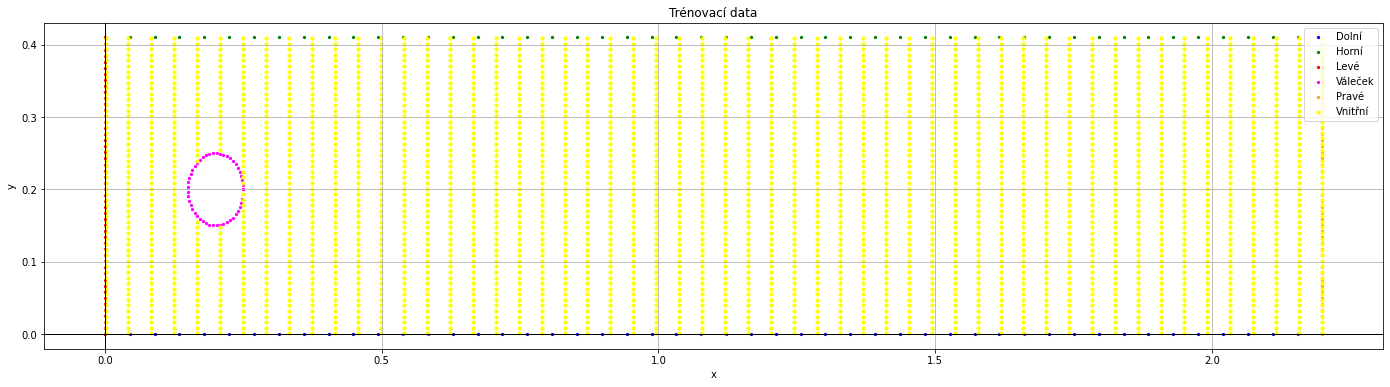

In [46]:
# Krok 3.1: Vygenerování trénovacích dat
x_train, y_train = generate_inner_train_data(3000)
x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle = generate_boundaries(50)
plot_boundaries(x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

In [47]:
# Krok 3.2: Inicializace modelu a nastavení optimalizátoru Adam
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [48]:
# Krok 4.1: Spuštění trénovací smyčky
epochs = 20000
best_model_state_dict = None
best_loss = float('inf')
loss_values = []
optim_change = epochs - 500
for epoch in range(epochs):
    if epoch <= optim_change:
        optimizer.zero_grad()
    
        # Výpočet ztráty
        loss = compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        loss = optimizer.step(closure)

    if epoch == optim_change:
        model.load_state_dict(best_model_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        best_model_state_dict = copy.deepcopy(model.state_dict())
    loss_values.append(loss.detach().numpy())
    if (epoch + 1) % 500 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')


Epocha 500/20000, Ztráta: 0.01842104084789753
Epocha 1000/20000, Ztráta: 0.00952689629048109
Epocha 1500/20000, Ztráta: 0.007379124406725168
Epocha 2000/20000, Ztráta: 0.0058059957809746265
Epocha 2500/20000, Ztráta: 0.005578358191996813
Epocha 3000/20000, Ztráta: 0.005271772388368845
Epocha 3500/20000, Ztráta: 0.004777542315423489
Epocha 4000/20000, Ztráta: 0.004446962382644415
Epocha 4500/20000, Ztráta: 0.003557936754077673
Epocha 5000/20000, Ztráta: 0.003226373577490449
Epocha 5500/20000, Ztráta: 0.0031638822983950377
Epocha 6000/20000, Ztráta: 0.0023150851484388113
Epocha 6500/20000, Ztráta: 0.0016301649156957865
Epocha 7000/20000, Ztráta: 0.001578852883540094
Epocha 7500/20000, Ztráta: 0.0014208757784217596
Epocha 8000/20000, Ztráta: 0.0025241386611014605
Epocha 8500/20000, Ztráta: 0.00043736971565522254
Epocha 9000/20000, Ztráta: 0.0004425983061082661
Epocha 9500/20000, Ztráta: 0.0005190536030568182
Epocha 10000/20000, Ztráta: 0.0003476864076219499
Epocha 10500/20000, Ztráta: 0.0

Nejlepší epocha 19687, Ztráta: 6.30594659014605e-05


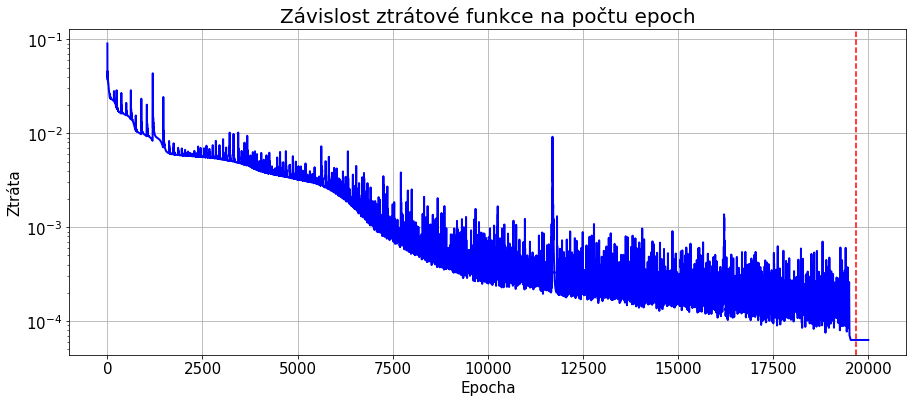

In [49]:
# Krok 4.2: Vykreslení hodnoty ztrátové funkce v závislosti na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(15, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=20)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

In [50]:
# Krok 4.3: Uložení nastavení modelu
#torch.save(model.state_dict(), 'pinn_navierstokes.pt')
model = MyModel()
model.load_state_dict(torch.load('pinn_navierstokes.pt'))

C:\Users\kater\AppData\Local\Temp/ipykernel_14840/3480731742.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pinn_navierstokes.pt'))


<All keys matched successfully>

In [51]:
# Krok 5.1: Vygenerování testovacích dat a získání predikcí
x_test, y_test = generate_test_data_lhs(20000)
x_test.requires_grad_(True)
y_test.requires_grad_(True)
inputs = torch.cat([x_test, y_test], dim=1)
outputs_pred = model(inputs) 
psi_pred, p_pred = outputs_pred[:, 0], outputs_pred[:, 1]
# Vykreslení testovacích dat
#plt.figure(figsize=(25, 4))
#plt.scatter(x_test.detach().cpu().numpy().squeeze(), y_test.detach().cpu().numpy().squeeze(), s=2)

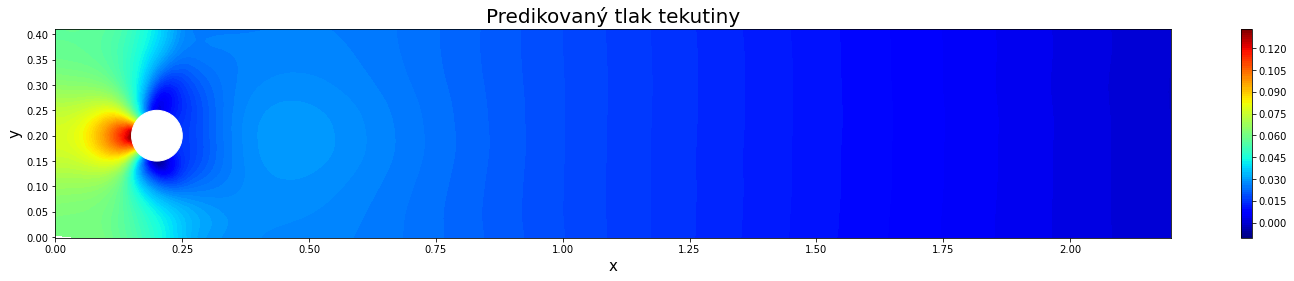

In [52]:
# Krok 5.2: Vykreslení predikovaného tlaku proudící tekutiny
x = x_test.detach().cpu().numpy().squeeze()
y = y_test.detach().cpu().numpy().squeeze()
z = p_pred.detach().cpu().numpy().squeeze()

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)
fig, ax = plt.subplots(figsize=(25, 3.85))#figsize=(25, 4)
contour = ax.tricontourf(x, y, z, levels=100, cmap="jet")
plt.colorbar(contour)
ax.add_patch(circle)
ax.set_xlabel("x", fontsize=15)
ax.set_ylabel("y", fontsize=15)
ax.set_title("Predikovaný tlak tekutiny", fontsize=20)
plt.axis("equal")
plt.show()

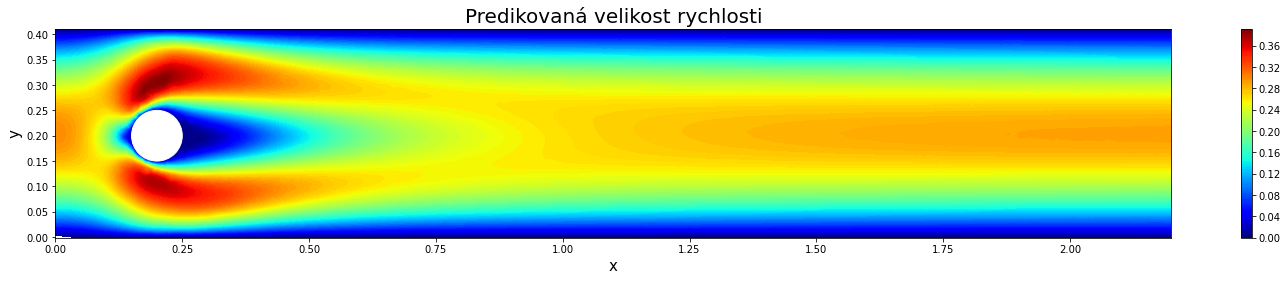

In [53]:
# Krok 5.3: Vykreslení predikované velikosti rychlosti proudící tekutiny
v_pred = -1*grad(psi_pred, inputs, torch.ones_like(psi_pred), create_graph=True)[0][:, 0:1]  # du/dx
u_pred = grad(psi_pred, inputs, torch.ones_like(psi_pred), create_graph=True)[0][:, 1:2]  # du/dy
velocity_magnitude = torch.sqrt(u_pred**2 + v_pred**2)

x_np = x_test.detach().cpu().numpy().flatten()
y_np = y_test.detach().cpu().numpy().flatten()
vel_mag_np = velocity_magnitude.detach().cpu().numpy().flatten()

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)

fig, ax = plt.subplots(figsize=(25, 3.85))
contour = ax.tricontourf(x_np, y_np, vel_mag_np, levels=100, cmap="jet")
plt.colorbar(contour)
ax.add_patch(circle)
ax.set_xlabel("x", fontsize=15)
ax.set_ylabel("y", fontsize=15)
ax.set_title("Predikovaná velikost rychlosti", fontsize=20)
plt.axis("equal")
plt.show()

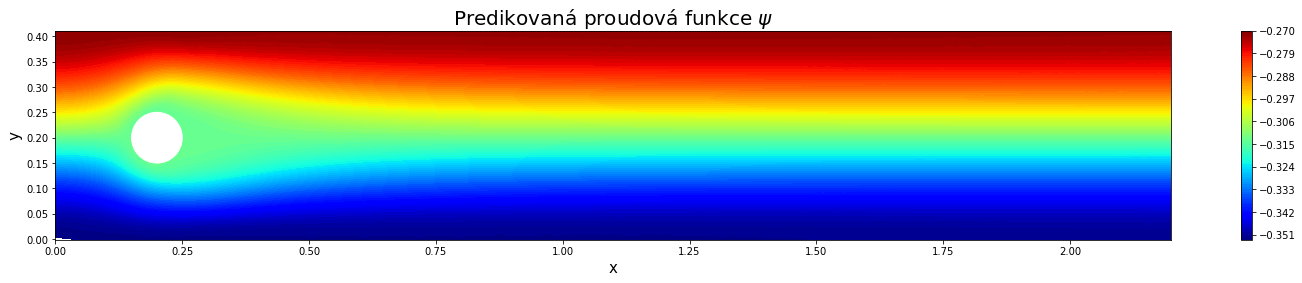

In [54]:
# Krok 5.4: Vykreslení predikované prodové funkce proudící tekutiny
psi_np = psi_pred.detach().cpu().numpy().flatten()

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)
fig, ax = plt.subplots(figsize=(25, 3.85))
contour = ax.tricontourf(x_np, y_np, psi_np, levels=100, cmap="jet")
plt.colorbar(contour)
ax.add_patch(circle)
ax.set_xlabel("x", fontsize=15)
ax.set_ylabel("y", fontsize=15)
ax.set_title("Predikovaná proudová funkce $\psi$", fontsize=20)
plt.axis("equal")
plt.show()